<a href="https://www.kaggle.com/code/ibrahimnibrahim/vegetables-classification-test-99-accuracy?scriptVersionId=244239884" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.applications import EfficientNetB3
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras import layers, models

2025-06-07 14:55:41.734807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749308141.921749      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749308141.983170      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
TRAIN_FOLDER='/kaggle/input/vegetable-image-dataset/Vegetable Images/train/'
TEST_FOLDER='/kaggle/input/vegetable-image-dataset/Vegetable Images/test/'
VALIDATION_FOLDER='/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/'

In [3]:
train= tf.keras.utils.image_dataset_from_directory(
    directory=TRAIN_FOLDER,            
    label_mode='categorical',        
    image_size=(224, 224),  
    batch_size=64                    
)

test= tf.keras.utils.image_dataset_from_directory(
    directory=TEST_FOLDER,            
    label_mode='categorical',        
    image_size=(224, 224),  
    batch_size=64                    
)

validation= tf.keras.utils.image_dataset_from_directory(
    directory=VALIDATION_FOLDER,            
    label_mode='categorical',        
    image_size=(224, 224),  
    batch_size=64                    
)

class_names=train.class_names

Found 15000 files belonging to 15 classes.


I0000 00:00:1749308174.375526      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


In [4]:
train=train.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(buffer_size=1000)
test=test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation=validation.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:

base_model = EfficientNetB3(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False    
)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)        
x = base_model(x, training=False)        
x = layers.GlobalAveragePooling2D()(x)    
x = layers.Dense(512, activation='relu')(x)  
x = layers.Dense(15, activation='softmax')(x) 

final_model = models.Model(inputs=inputs, outputs=x)

final_model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,578,174 (44.17 MB)

 Trainable params: 11,490,871 (43.83 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [6]:
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,  
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=3, 
    min_lr=1e-7
)


class StopOnValAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target=0.985):
        super().__init__()
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None and val_acc >= self.target:
            print(f"\nReached {val_acc:.2%} val_accuracy — stopping training.")
            self.model.stop_training = True

In [8]:
history = final_model.fit(
    train,
    validation_data=validation,
    epochs=100,
    callbacks=[early_stopping, reduce_lr,StopOnValAccuracy(target=0.995)]
)

Epoch 1/100


E0000 00:00:1749308268.012309      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1749308318.570781      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


235/235 ━━━━━━━━━━━━━━━━━━━━ 350s 916ms/step - accuracy: 0.9013 - loss: 0.3781 - val_accuracy: 0.9277 - val_loss: 1.1771 - learning_rate: 0.0010
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 208s 885ms/step - accuracy: 0.9805 - loss: 0.0891 - val_accuracy: 0.9440 - val_loss: 0.5259 - learning_rate: 0.0010
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 208s 886ms/step - accuracy: 0.9887 - loss: 0.0481 - val_accuracy: 0.9637 - val_loss: 0.1603 - learning_rate: 0.0010
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 208s 884ms/step - accuracy: 0.9887 - loss: 0.0464 - val_accuracy: 0.8840 - val_loss: 1.1409 - learning_rate: 0.0010
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 208s 885ms/step - accuracy: 0.9875 - loss: 0.0414 - val_accuracy: 0.9707 - val_loss: 0.1164 - learning_rate: 0.0010
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.9925 - loss: 0.0297
Reached 99.77% val_accuracy — stopping training.
235/235 ━━━━━━━━━━━━━━━━━━━━ 208s 885ms/step - accuracy: 0.9925 - loss: 0.0297 - val_accu

In [9]:
final_model.evaluate(test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9959 - loss: 0.0171


[0.014185619540512562, 0.9963333606719971]

In [10]:
y_true = []
y_pred_probs = []

for images, labels in test:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(final_model.predict(images, verbose=0))

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Check if labels are one-hot encoded
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

y_pred = np.argmax(y_pred_probs, axis=1)

report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

        Bean     1.0000    1.0000    1.0000       200
Bitter_Gourd     0.9950    0.9900    0.9925       200
Bottle_Gourd     1.0000    1.0000    1.0000       200
     Brinjal     0.9900    0.9950    0.9925       200
    Broccoli     0.9901    1.0000    0.9950       200
     Cabbage     0.9950    1.0000    0.9975       200
    Capsicum     1.0000    1.0000    1.0000       200
      Carrot     1.0000    1.0000    1.0000       200
 Cauliflower     0.9950    1.0000    0.9975       200
    Cucumber     0.9804    1.0000    0.9901       200
      Papaya     1.0000    0.9750    0.9873       200
      Potato     1.0000    1.0000    1.0000       200
     Pumpkin     1.0000    0.9900    0.9950       200
      Radish     1.0000    1.0000    1.0000       200
      Tomato     1.0000    0.9950    0.9975       200

    accuracy                         0.9963      3000
   macro avg     0.9964    0.9963    0.9963      3000
wei

In [11]:
y_true = []
y_pred_probs = []

for images, labels in validation:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(final_model.predict(images, verbose=0))

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Check if labels are one-hot encoded
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

y_pred = np.argmax(y_pred_probs, axis=1)

report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

        Bean     1.0000    1.0000    1.0000       200
Bitter_Gourd     1.0000    1.0000    1.0000       200
Bottle_Gourd     1.0000    1.0000    1.0000       200
     Brinjal     0.9901    1.0000    0.9950       200
    Broccoli     1.0000    1.0000    1.0000       200
     Cabbage     1.0000    1.0000    1.0000       200
    Capsicum     0.9950    1.0000    0.9975       200
      Carrot     0.9950    1.0000    0.9975       200
 Cauliflower     1.0000    1.0000    1.0000       200
    Cucumber     0.9901    1.0000    0.9950       200
      Papaya     1.0000    0.9750    0.9873       200
      Potato     1.0000    1.0000    1.0000       200
     Pumpkin     1.0000    1.0000    1.0000       200
      Radish     1.0000    0.9950    0.9975       200
      Tomato     0.9950    0.9950    0.9950       200

    accuracy                         0.9977      3000
   macro avg     0.9977    0.9977    0.9977      3000
wei

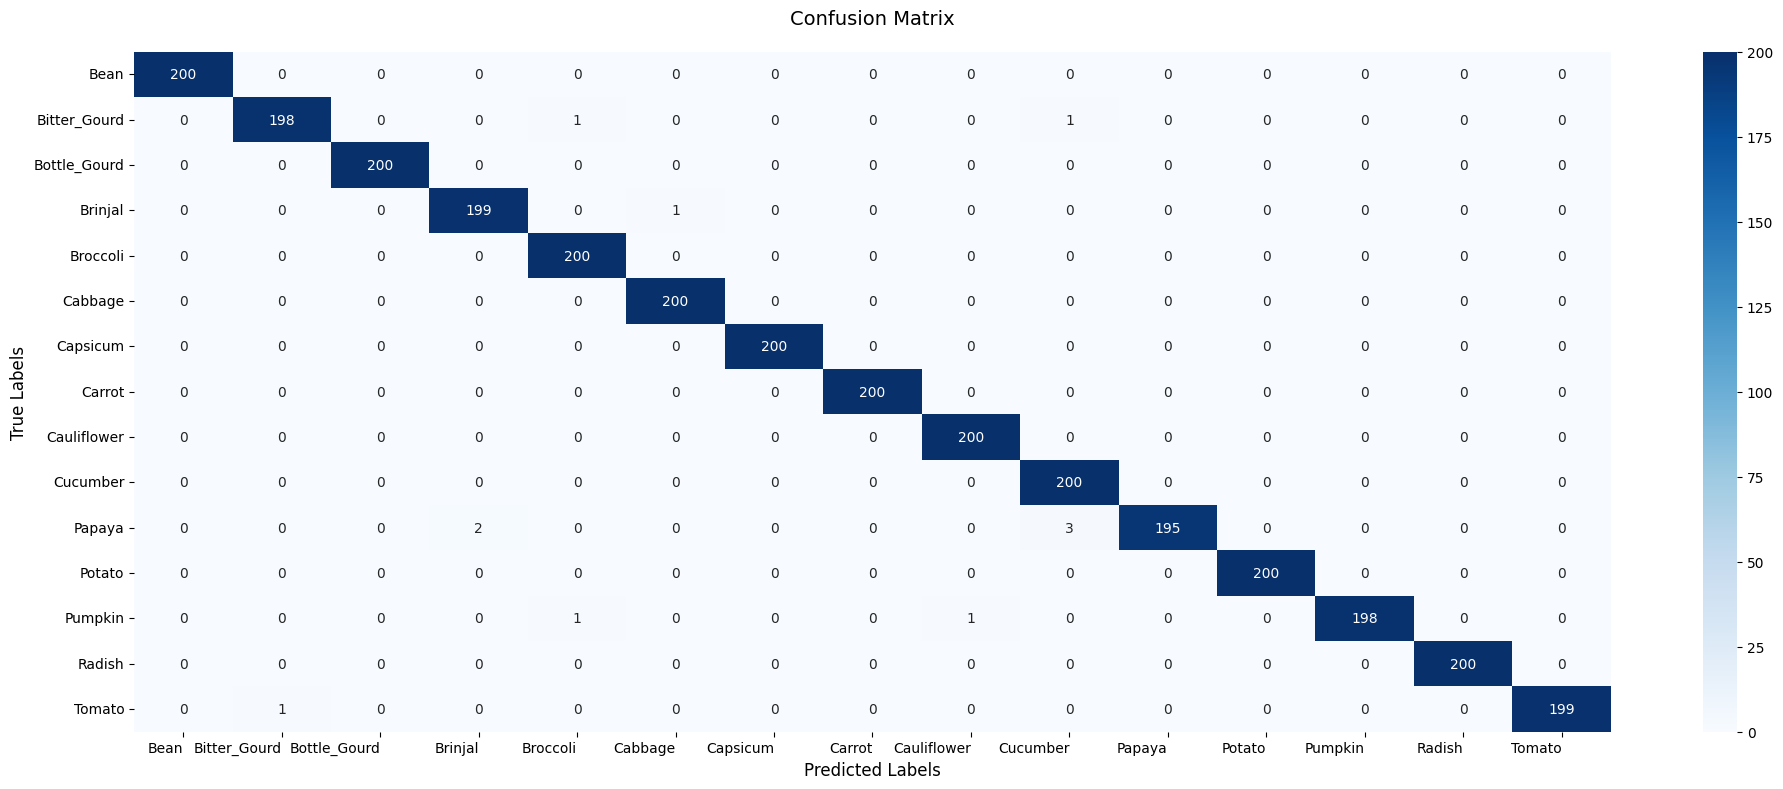

In [12]:
# 1. Get predictions and true labels
y_true = []
y_pred = []

for images, labels in test:
    # Get true labels (convert from one-hot if needed)
    if len(labels.shape) > 1:  # If one-hot encoded
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    else:
        y_true.extend(labels.numpy())
    
    # Get predictions
    preds = final_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

# 2. Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Create figure
plt.figure(figsize=(20, 8))

# 4. Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)

# 5. Add labels and title
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, pad=20)

# 6. Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='right')
plt.yticks(rotation=0)

# 7. Adjust layout
plt.tight_layout()
plt.show()

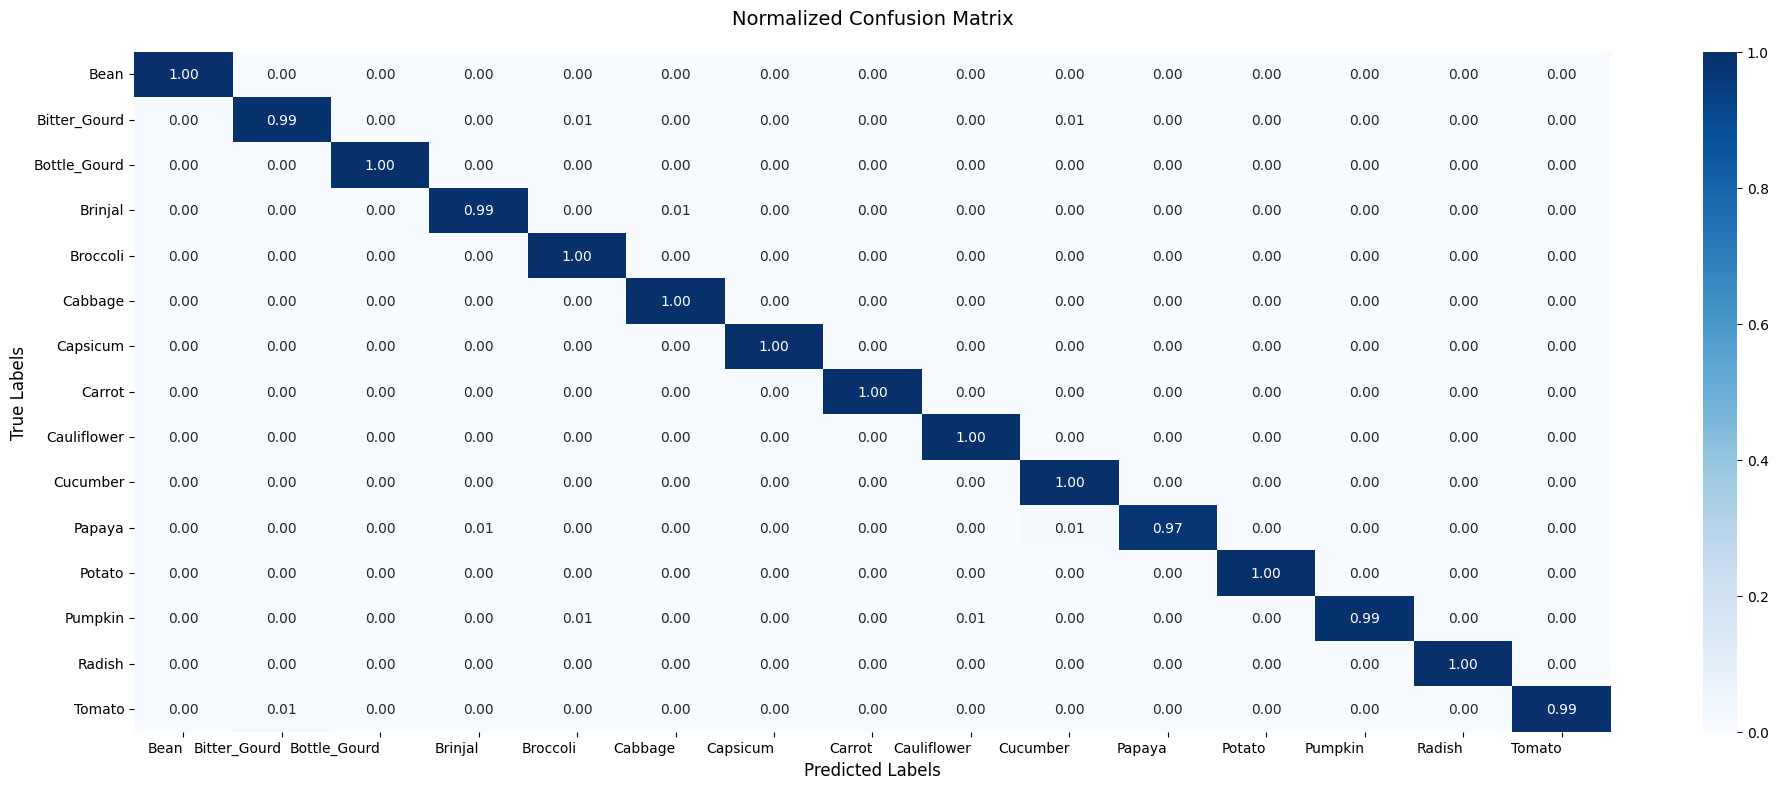

In [13]:
# 1. Get predictions and true labels
y_true = []
y_pred = []

for images, labels in test:
    # Get true labels (convert from one-hot if needed)
    if len(labels.shape) > 1:  # If one-hot encoded
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    else:
        y_true.extend(labels.numpy())
    
    # Get predictions
    preds = final_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

# 2. Compute confusion matrix and normalize it
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 3. Create figure
plt.figure(figsize=(20, 8))

# 4. Create heatmap with normalized values
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names,
            vmin=0, vmax=1)

# 5. Add labels and title
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Normalized Confusion Matrix', fontsize=14, pad=20)

# 6. Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='right')

# 7. Adjust layout
plt.tight_layout()
plt.show()

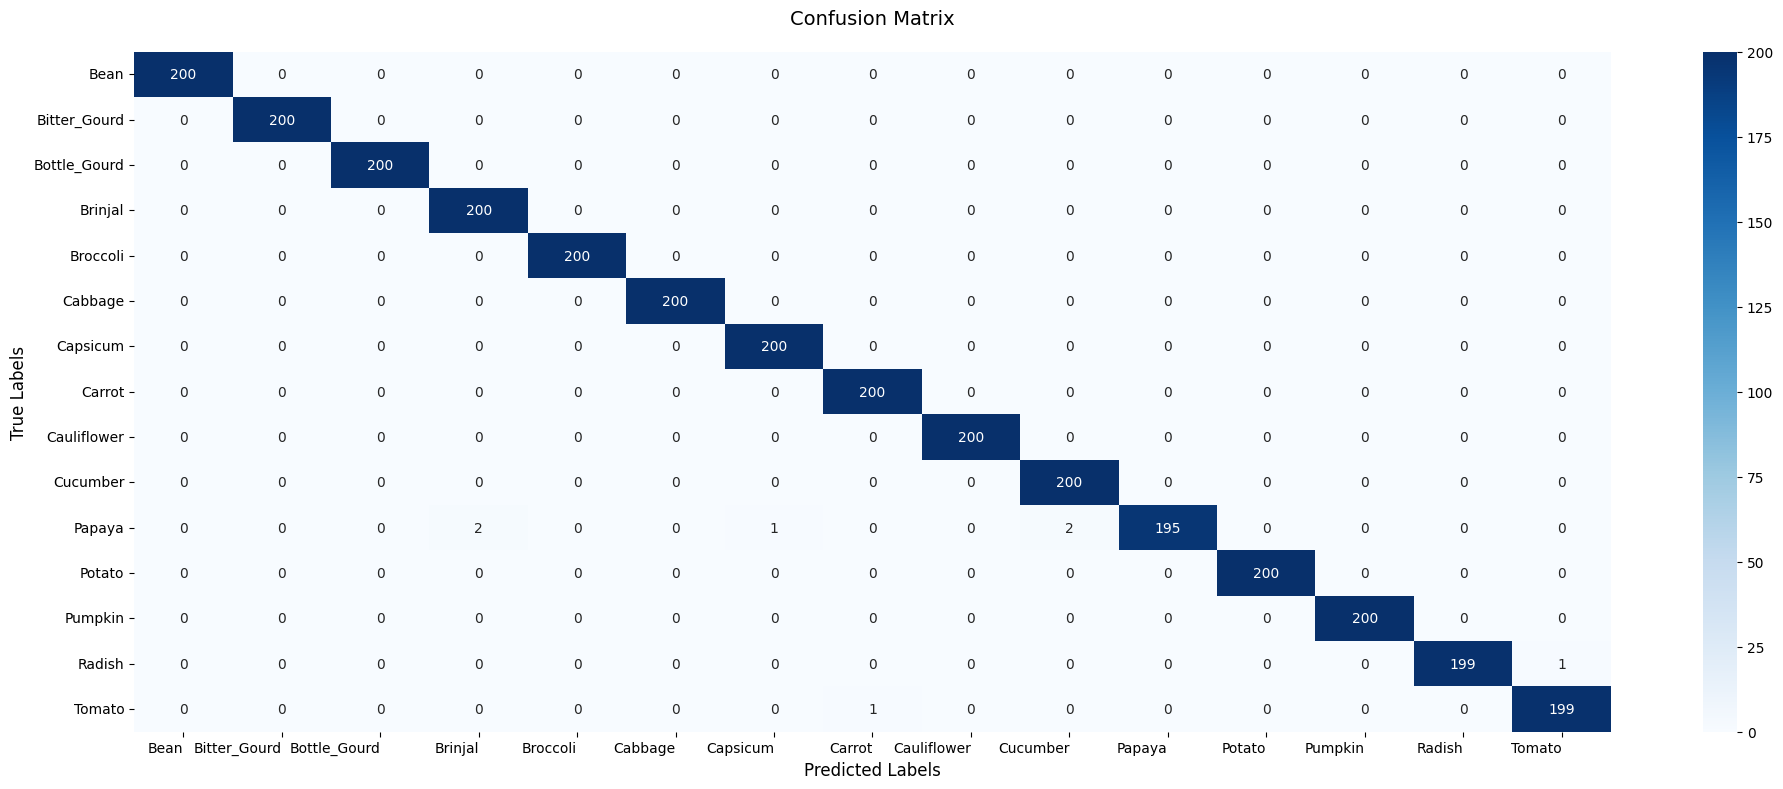

In [14]:
# 1. Get predictions and true labels
y_true = []
y_pred = []

for images, labels in validation:
    # Get true labels (convert from one-hot if needed)
    if len(labels.shape) > 1:  # If one-hot encoded
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    else:
        y_true.extend(labels.numpy())
    
    # Get predictions
    preds = final_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

# 2. Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Create figure
plt.figure(figsize=(20, 8))

# 4. Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)

# 5. Add labels and title
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, pad=20)

# 6. Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='right')
plt.yticks(rotation=0)

# 7. Adjust layout
plt.tight_layout()
plt.show()

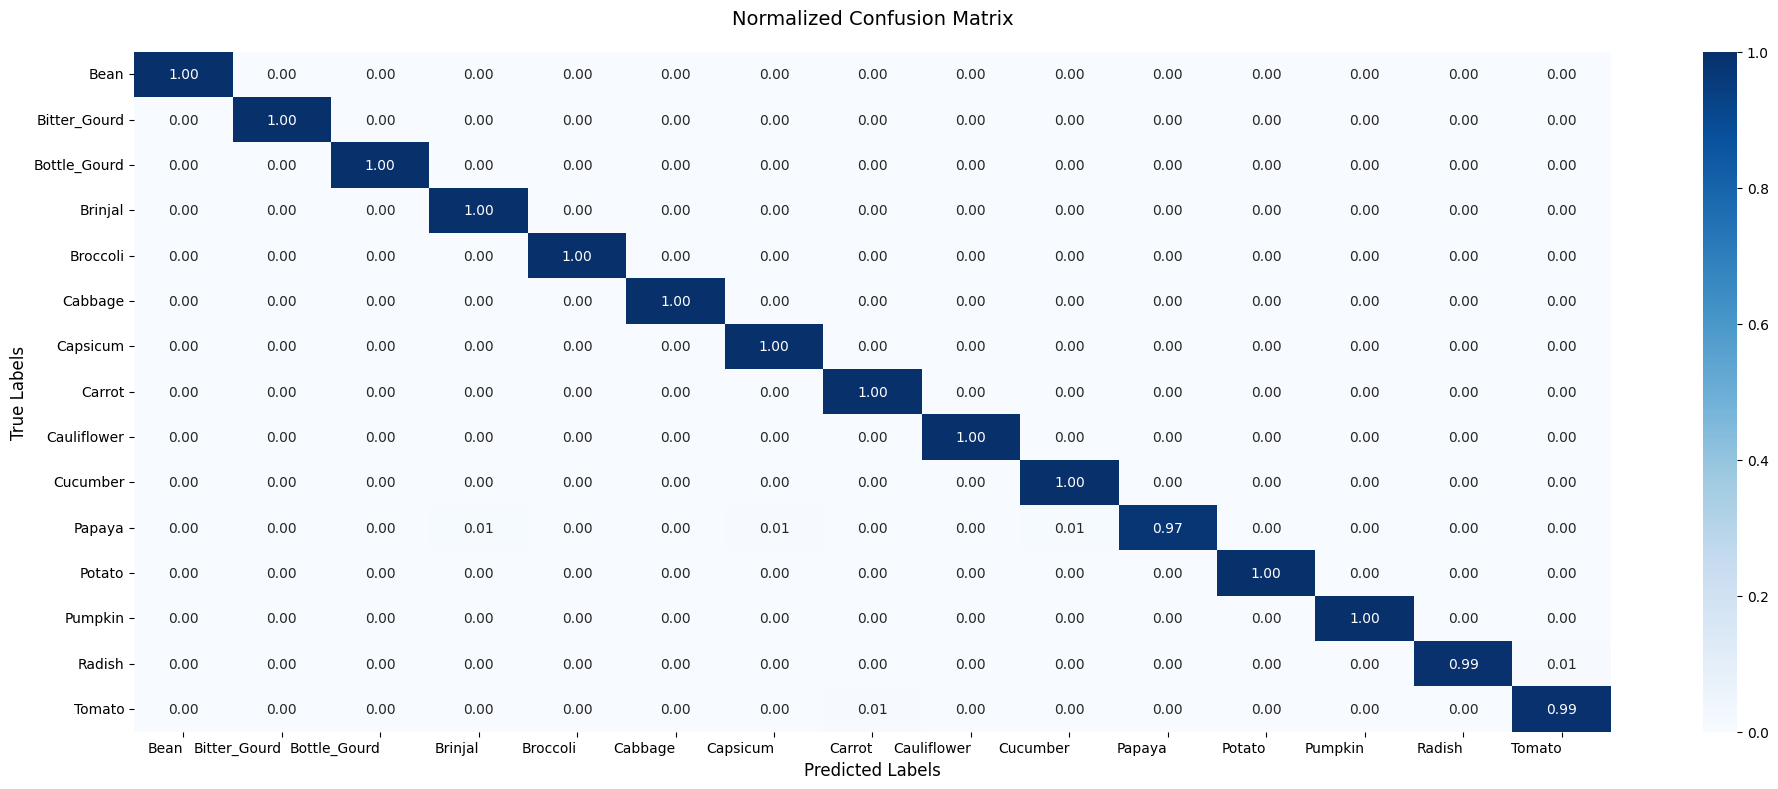

In [15]:
# 1. Get predictions and true labels
y_true = []
y_pred = []

for images, labels in validation:
    # Get true labels (convert from one-hot if needed)
    if len(labels.shape) > 1:  # If one-hot encoded
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    else:
        y_true.extend(labels.numpy())
    
    # Get predictions
    preds = final_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

# 2. Compute confusion matrix and normalize it
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 3. Create figure
plt.figure(figsize=(20, 8))

# 4. Create heatmap with normalized values
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names,
            vmin=0, vmax=1)

# 5. Add labels and title
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Normalized Confusion Matrix', fontsize=14, pad=20)

# 6. Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='right')

# 7. Adjust layout
plt.tight_layout()
plt.show()

In [16]:
def plot_predictions(model, dataset, class_names, num_images=16):
    """
    Plots images with their true and predicted labels in a 4x4 grid
    
    Args:
        model: Trained Keras model
        dataset: TensorFlow dataset (batched)
        class_names: List of class names
        num_images: Number of images to display (default 16)
    """
    plt.figure(figsize=(16, 16))  # Increased figure size for better visibility
    
    # Take one batch from the dataset
    for images, labels in dataset.take(1):
        # Make predictions
        preds = model.predict(images, verbose=0)
        pred_classes = np.argmax(preds, axis=1)
        
        # Convert one-hot labels if needed
        if len(labels.shape) > 1:
            true_classes = np.argmax(labels.numpy(), axis=1)
        else:
            true_classes = labels.numpy()
        
        # Plot images in 4x4 grid
        for i in range(min(num_images, len(images))):
            ax = plt.subplot(4, 4, i+1)  # Changed to 4 rows, 4 columns
            plt.imshow(images[i].numpy().astype("uint8"))
            
            # Set title with color coding
            true_label = class_names[true_classes[i]]
            pred_label = class_names[pred_classes[i]]
            
            color = 'green' if true_label == pred_label else 'red'
            plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

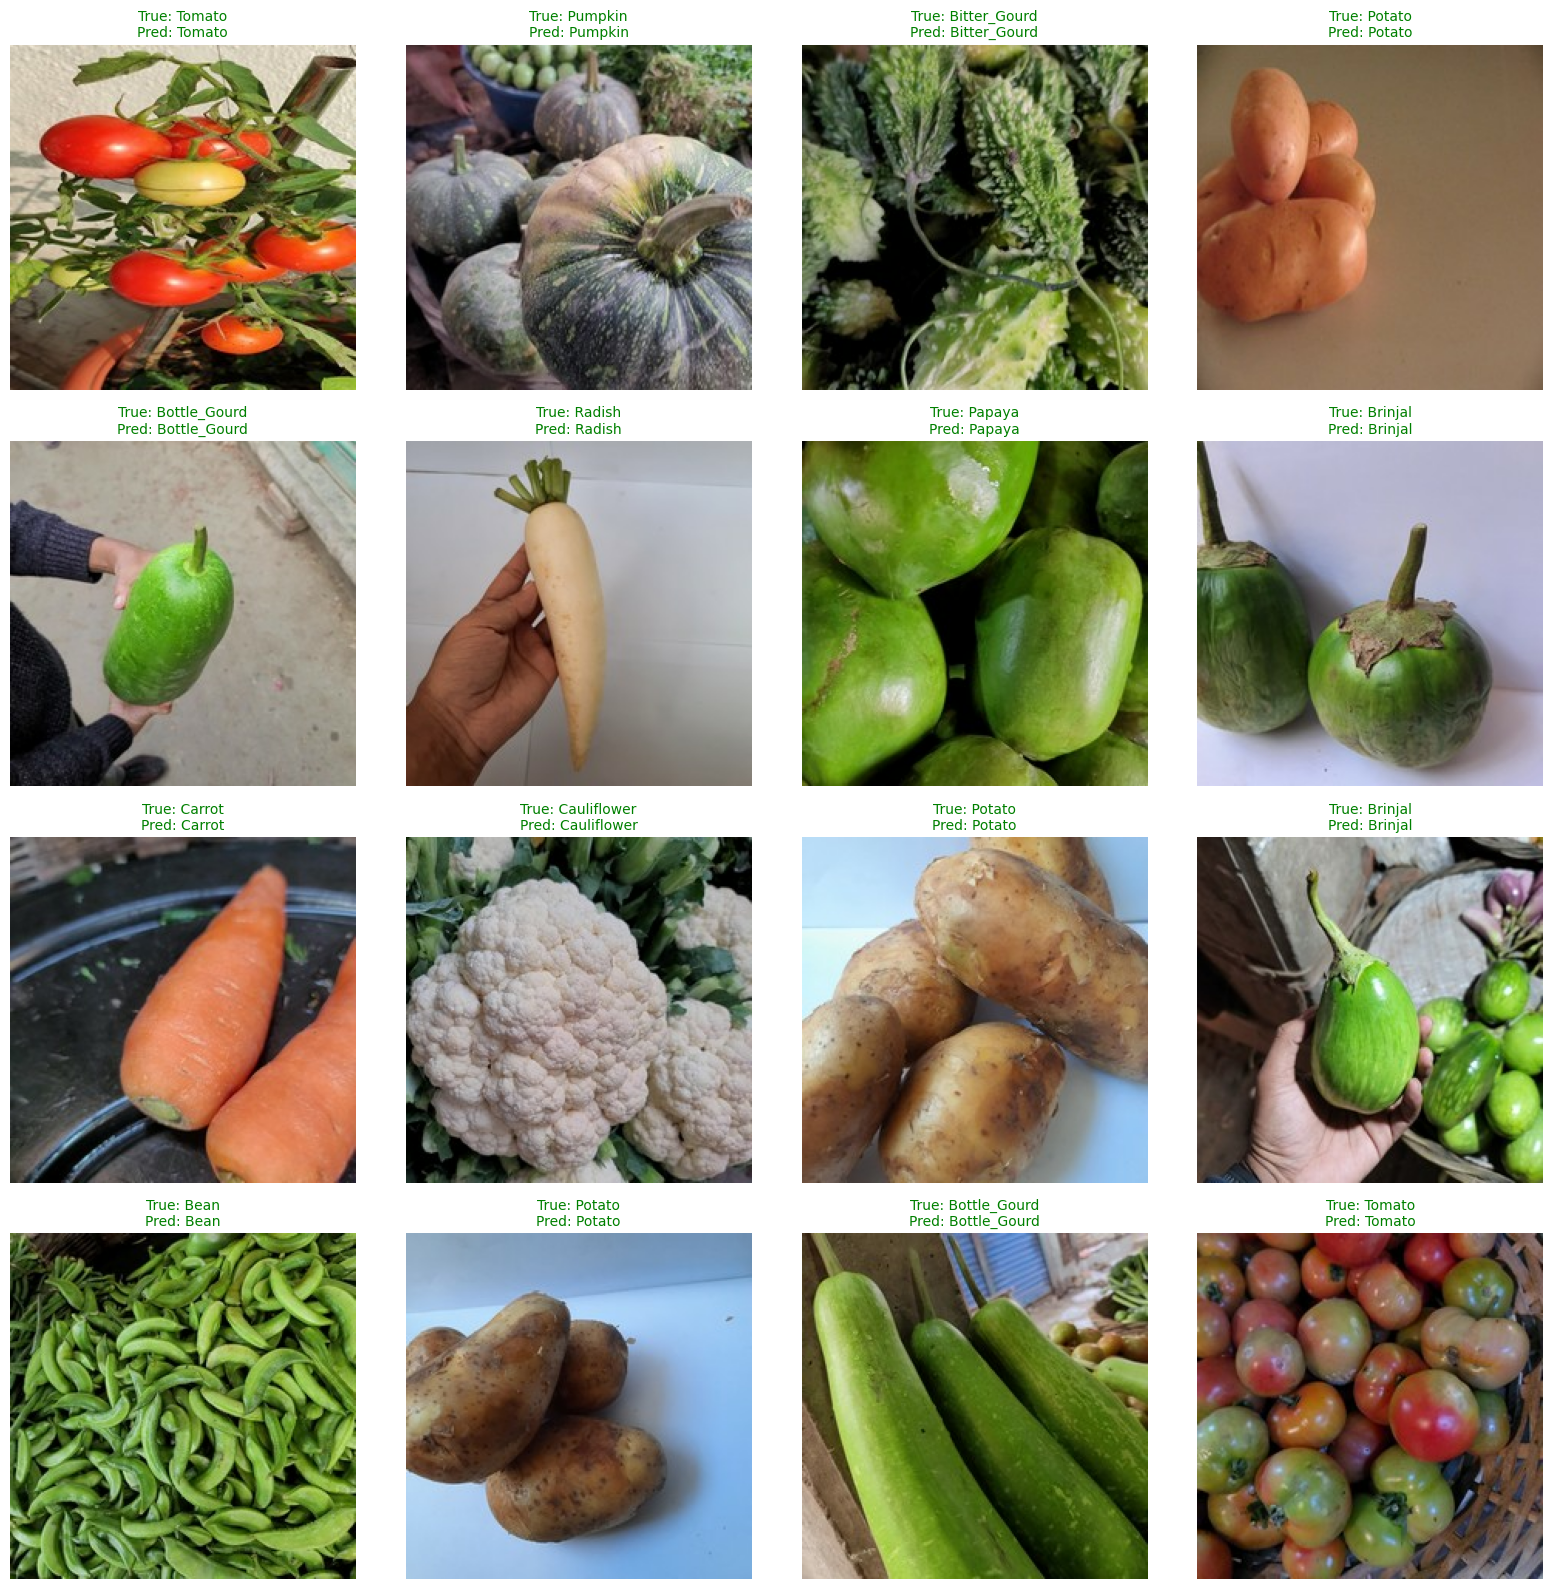

In [17]:
plot_predictions(final_model, test, class_names)

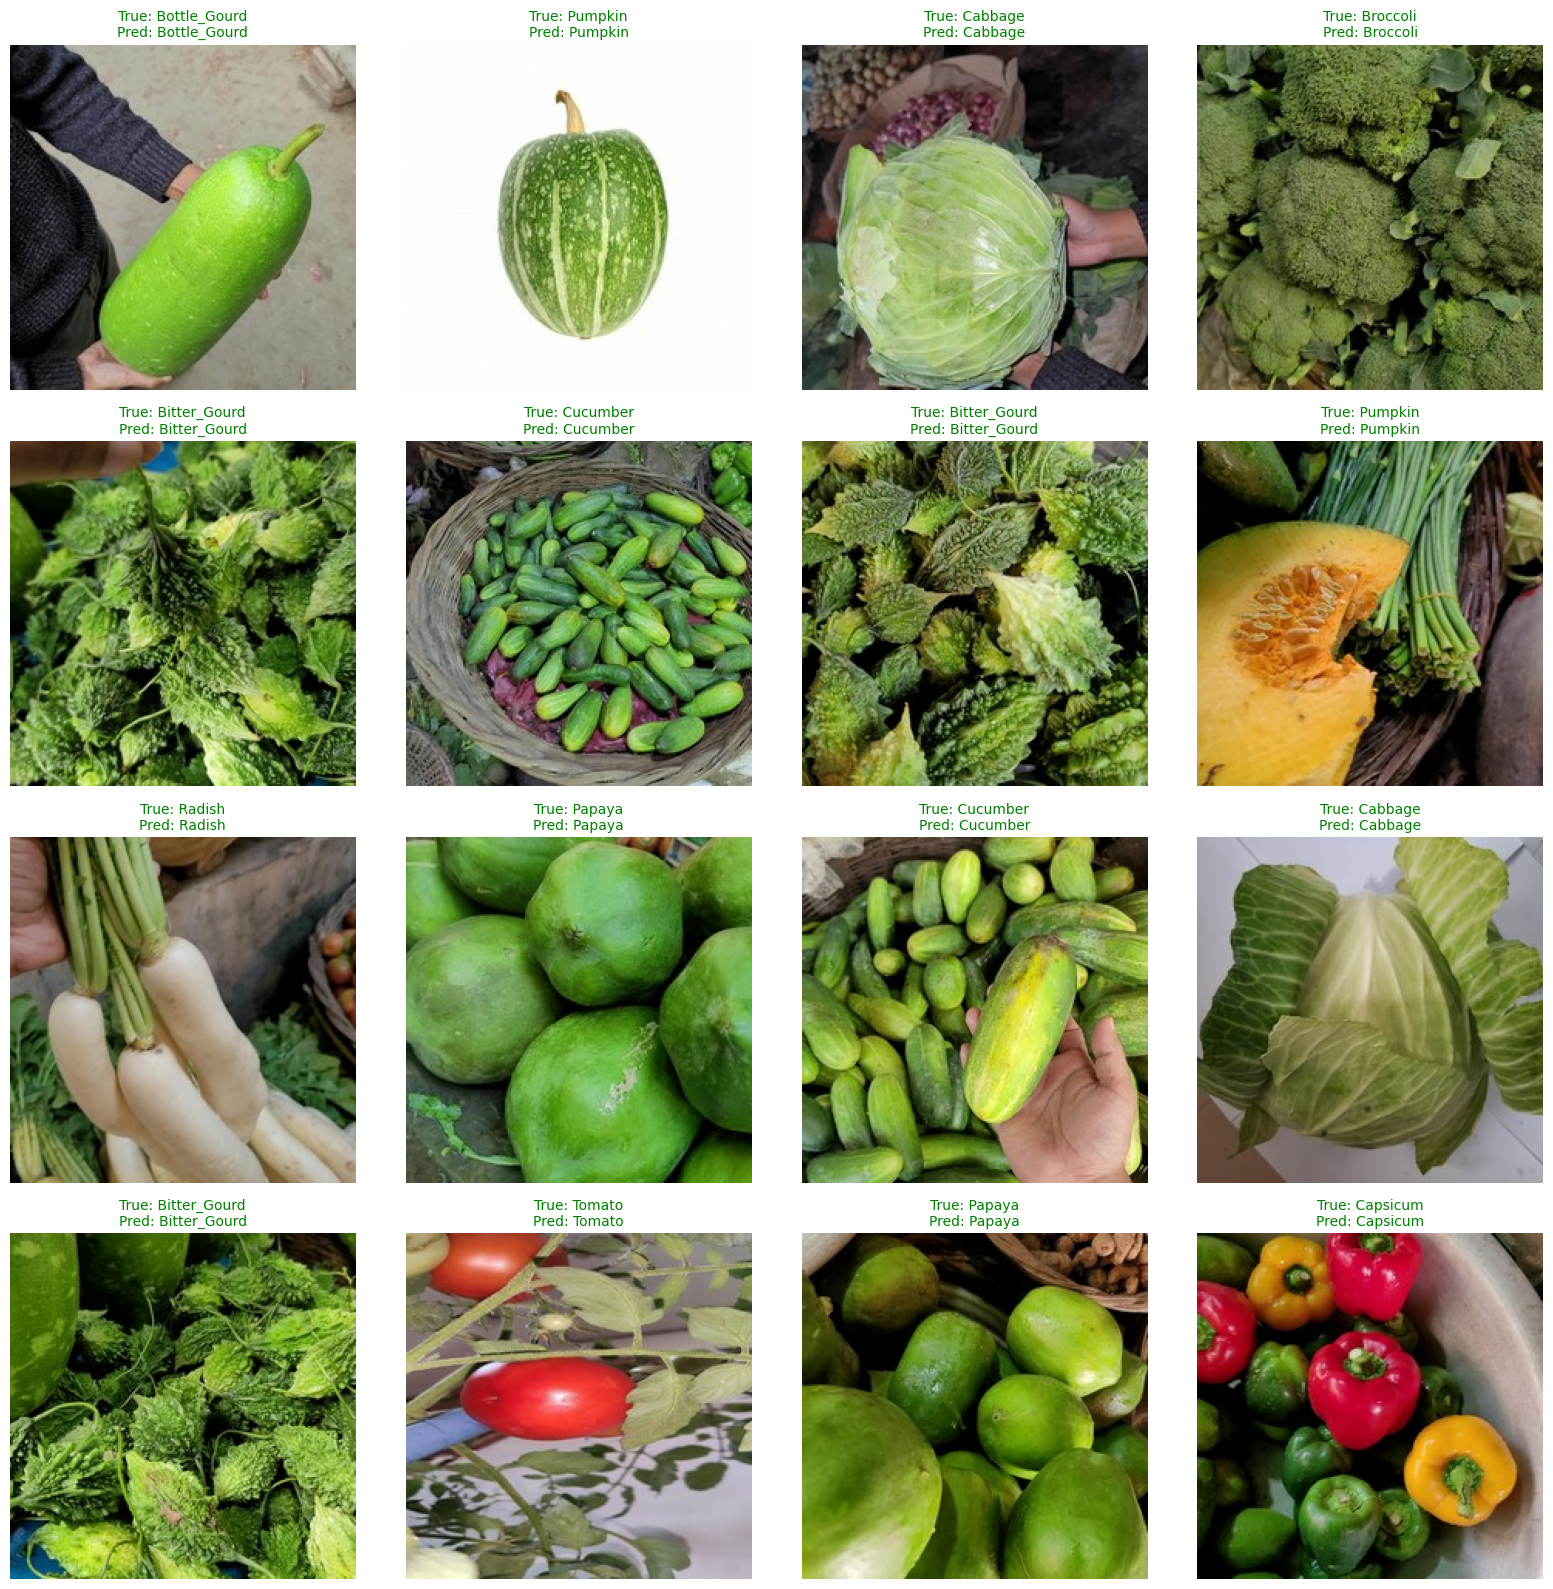

In [18]:
plot_predictions(final_model, validation, class_names)